<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-coloring-book/blob/master/main_coloring_book_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Interactiv Coloring Book**


![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/coloring_book_picture.png)

**Group Members**
* Johannes Scheibe
* Thilo von Glan 
* Jill Baumann

## **Project Planning**
"Create a coloring template out of a photo"

**Scenarios**
* embarrassingly colorbookly pictures
* blurred images
* high detailled images
* existing images from coloring books
* faces

**Steps**

0.   Accusation of Pictures 

*   We have now made some "easy to colorbook" pictures ourselves, still more could be made and "embarrassingly colorbookly" pictures from the internet may be acquired if need be.

1.   Preprocessing of picture

*   We have already tried out differnt methods and decided for these:
  * Loading of images
  * Gaussian Blur
  * Grayscale
  * Colorset
*   We have rewriten them to enable one to call these methods like functions so one is able to use differnt filters in quick succesion. We still haven't made a final decision on which filters we want to use and when.


2.   Image Segmantation

*   We have succesfully implemented our own form of the SLIC algorithim and also a well working color quantization and color replacing to segment pictures. For this form of SLIC we have written an addition, which outlines the pixels and removes all color from them except one pixel in the middle showing the mean color of each Superpixel. We have also found good parameters for Slic

*  Then we have also implemented a well functioning Face Recognition using landmarks.

*  Only thing remaining would be to combine both methods in one

3.   Postprocessing

*   After some tests we have decided that three functions could be interesting to us in the postprocessing of pictures:
  * Edge Detection
  * Canny
  * Adaptive Thresholding
  Just as with the preprocessing a final decision on what methods to use hasn't been made.

4.   Extracting Colors and assigning correct numbers to fields

*   We have implemted a version for Slic where colors are defined by one pixel in the middel for rhe larger superpixels. We will probably stick with this and not try to implement numbers yet



# **Project**

## **Requierd imports**

In [1]:
# Getting of Landmarks, only has to run once
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

--2020-01-16 12:02:47--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.9MB/s    in 4.8s    

2020-01-16 12:02:52 (12.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [0]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
import dlib
from PIL import Image, ImageDraw, ImageOps
from skimage.transform import resize

In [0]:
# Define the plot size
fig_size = [22,15]
plt.rcParams["figure.figsize"] = fig_size

## **Usefull functions**

We implemented the following functions to make our code clearer

In [0]:
# A single Image is loaded into colab and returned (name)
def load_image(name):
  link = "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/" + name
  ! wget $link  
  img = cv2.imread(name)
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return rgb

def resize_image(img, skimage = True):
    h = img.shape[0]
    w = img.shape[1]
    diff = abs(int((h - w)/2))
    if h < w:
      new_w = diff + h
      img = img[0:h, diff:new_w]
    elif h > w:
      new_h = diff + w
      img = img[diff:new_h, 0:w]
    if skimage:
      img = resize(img, (400,400),anti_aliasing=True)
    else:
      img = cv2.resize(img, (400,400))
    return img

## **Color set**

We decided to define a fixed color set, which should be used to colorize the final output. 

The set inculdes the following colors:

*   Red: RGB: 255,0,0 
*   Yellow: RGB: 236,226,40 
*   Green: RGB: 0,255,0 
*   Blue: RGB: 0,0,255
*   Pink: RGB: 255,0,255
*   Purple: RGB: 200,0,255
*   Light blue: RGB: 191,239,255 
*   Dark blue RGB: 25,25,112 
*   Dark Green: RGB: 0,99,0 
*   Skin: RGB: 255,229,196 
*   Brown: RGB: 140,92,43 
*   Light brown: RGB: 222,184,135 
*   Dark red: RGB: 140,0,0 
*   Gray: RGB: 204,204,204 
*   White: RGB: 255,255,255 
*   Black: RGB: 0,0,0 


We implemented the color set as an array and converted it to an image. This gives us the opportunity to convert the color set into another color space with the help of cv2.cvtColor()

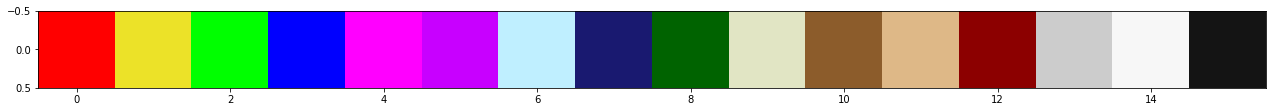

In [5]:
color_set_rgb = [[255,0,0],
             [236,226,40],
             [0,255,0],
             [0,0,255],
             [255,0,255],
             [200,0,255],
             [191,239,255],
             [25,25,112],
             [0,99,0],
             [225,229,196],
             [140,92,43],
             [222,184,135],
             [140,0,0],
             [204,204,204],
             [247,247,247],
             [20,20,20]]
             
            
color_set = np.zeros([1,len(color_set_rgb), 3], dtype=np.uint8)
for i in range(0,len(color_set_rgb)):
  color_set[0][i] = color_set_rgb[i]

plt.imshow(color_set)

## **Input**

In [6]:
input = load_image("face1.JPG")

--2020-01-16 12:03:05--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-coloring-book/master/images/face1.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6521344 (6.2M) [application/octet-stream]
Saving to: ‘face1.JPG’

face1.JPG           100%[===================>]   6.22M  --.-KB/s    in 0.1s    

2020-01-16 12:03:05 (47.0 MB/s) - ‘face1.JPG’ saved [6521344/6521344]



## **Face detection**

One defined Scenario is faces, which we need to handle separately.

So our first step is to detect this faces using landmark detection. The code is based on Andrew Jones implemantation and has a few adjustments.

Source: https://www.analytics-link.com/single-post/2019/07/17/Mapping-Facial-Landmarks-in-Python-using-OpenCV

In [0]:
# set up the 68 point facial landmark detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# convert to grayscale
img_gray = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)

# detect faces in the image
faces_in_image = detector(img_gray, 0)

# loop through each face in image
for face in faces_in_image:

  # assign the facial landmarks
  landmarks = predictor(img_gray, face)

  # unpack the needed landmark coordinates for the face regions from the dlib object into a list 
  face = []
  eyes = []
  mouth = []
  nose = []
  # face
  for i in range(0, 16):
    face.append((landmarks.part(i).x, landmarks.part(i).y))
  for i in range(0, 10):
    face.append((landmarks.part(26-i).x, landmarks.part(26-i).y))

In the next step we create a mask for the face regions:

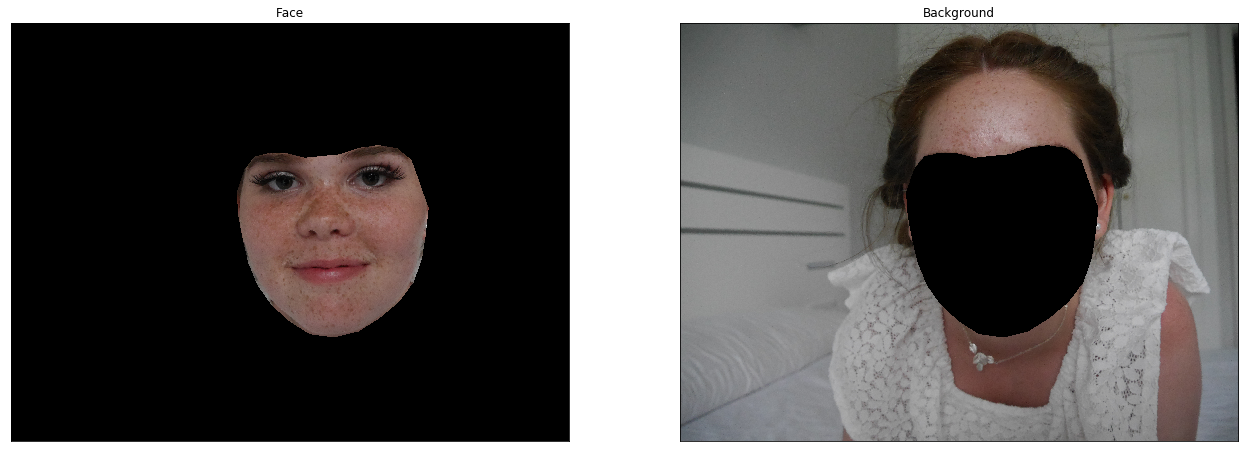

In [9]:
height = input.shape[0]
width = input.shape[1]

mask = Image.new('L', (width, height), 0)
ImageDraw.Draw(mask).polygon(face, outline=1, fill=1)
mask = np.array(mask)
face_mask = np.stack((mask,)*3, axis=-1)
output_face = input * face_mask

back_mask = (1-face_mask)
output_back = input * back_mask

images = [output_face,output_back]
titles = ['Face','Background']
for i in range(len(images)):
    plt.subplot(1,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

## **SLIC**

SLIC is a clustering algorithm that segments an image based on the color similarities of the pixels.
The code is a combination of the implementation from Darshita Jain, Aleena Watson and own additions.

Sources: 
https://github.com/darshitajain/SLIC 
https://github.com/aleenawatson/SLIC_superpixels/blob/master/slic.py

In our project SLIC is used for the background and images without faces.

**Functions:**

In [0]:
# function which returns an object of class SuperPixel(height, weidth, l, a, b). Superpixels have a center(h,w) and a color(lab)
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

In [0]:
# To define the initial cluster centers distanced at S
def initial_cluster_center(S,img,img_h,img_w,clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

In [0]:
# function to calculate gradient at each pixel.
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad

In [0]:
# function which reassign for each cluster the cluster center to the pixel having the lowest gradient
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient


In [0]:
#function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial proximity.
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [0]:
#function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial proximity.
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [0]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [0]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [0]:
# replace the color of each pixel in a cluster by the color of the cluster's center
def avg_color_cluster(img, clusters):
    image = np.copy(img)
    color_set_lab = color.rgb2lab(color_set)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to the matching color from the color set  
        for j in range(0,len(color_set[0])):
            a = color_set_lab[0][j]
            b = [c.l,c.a,c.b]
            value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
            if(j==0):
                best_value = value
                image[c.h, c.w][0] = a[0]
                image[c.h, c.w][1] = a[1]
                image[c.h, c.w][2] = a[2]
            elif(value<best_value):
                image[c.h, c.w][0] = a[0]
                image[c.h, c.w][1] = a[1]
                image[c.h, c.w][2] = a[2]
                best_value = value 
    return color.lab2rgb(image)

In [0]:
# outline the boarder of each cluster
def display_contours(img, clusters):
    image = np.zeros([400,400, 3], dtype=np.uint8)
    image.fill(255)
    image = color.rgb2lab(image)
    
    cluster_map = -1 * np.ones(img.shape[:2])
    for i in range(0,len(clusters)):
        c = clusters[i]
        for p in c.pixels: 
            cluster_map[p[0],p[1]] = i

    is_taken = np.zeros(image.shape[:2], np.bool)
    contours = []

    for i in range(img_w):
        for j in range(img_h):
            nr_p = 0
            for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]:
                x = i + dx
                y = j + dy
                if x>=0 and x < img_w and y>=0 and y < img_h:
                    if is_taken[y, x] == False and cluster_map[j, i] != cluster_map[y, x]:
                        nr_p += 1
            if nr_p >= 2:
                is_taken[j, i] = True
                contours.append([j, i])
    for i in range(len(contours)):
        image[contours[i][0], contours[i][1]] = [0.0, 0.0, 0.0]
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image,kernel,iterations = 1)

    # To change the color of cluster center to the matching color from the color set  
    color_set_lab = color.rgb2lab(color_set)
    for c in clusters:
        for j in range(0,len(color_set[0])):
            a = color_set_lab[0][j]
            b = [c.l,c.a,c.b]
            value = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)
            if(j==0):
                best_value = value
                for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (0,0)]:
                  h = c.h + dx
                  w = c.w + dy
                  image[h, w][0] = a[0]
                  image[h, w][1] = a[1]
                  image[h, w][2] = a[2]
            elif(value<best_value):
                best_value = value 
                for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (0,0)]:
                  h = c.h + dx
                  w = c.w + dy
                  image[h, w][0] = a[0]
                  image[h, w][1] = a[1]
                  image[h, w][2] = a[2]
    return color.lab2rgb(image)

In [0]:
# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [0]:
def slic(S,img,img_h,img_w,clusters,tag,dis,iter):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(iter): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == (iter - 1) : # to print the output after 10 iterations
            output = avg_color_cluster(img, clusters)
            outline = display_contours(img, clusters)
    return outline, output

**Execution**

In [0]:
# input images are resized to (400 x 400) for processing
img = resize_image(input)

# convert RGB to LAB
img = color.rgb2lab(img)

k = 400   # Number of Super pixels
m = 21    # Constant for normalizing the color proximity, range of m = [1,40]

img_h = img.shape[0] # Image Height
img_w = img.shape[1] # Image Width

N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N /k)) # average size of each superpixel

clusters = []
tag = {}
# initialize the distance between pixels and cluster center as infinity
dis = np.full((img_h, img_w), np.inf)

outline,output = slic_run(S,img,img_h,img_w,clusters,tag,dis,7)


fig_size = [22,15]
plt.rcParams["figure.figsize"] = fig_size

#fig = plt.figure("Superpixels -- %d segments" % (400))
#ax = fig.add_subplot(1, 1, 1)
#ax.imshow(mark_boundaries(output, segments))
#plt.axis("off")
images = [output,outline]
for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(images[i], cmap='gray')
    plt.xticks([]),plt.yticks([])